##### Author  : SIVA VIKNESH
##### Email   : siva.viknesh@sci.utah.edu / sivaviknesh14@gmail.com
##### Address : SCI INSTITUTE, UNIVERSITY OF UTAH, SALT LAKE CITY, UTAH, USA

In [1]:
import os
import torch
import math
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as plticker
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import circulant, toeplitz, inv
import h5py

rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]

Asensio & Ferragut: Wildfire combustion model

$$
\begin{align}
\frac{\partial \overline{T}}{\partial \tau} + \overrightarrow{\mathbf{V}} \cdot \nabla \overline{T} &= \overline{\kappa} \nabla^2 \overline{T} + \beta \mathrm{e}^{\overline{T}/(1 + \epsilon \overline{T})} - \alpha \overline{T} \\[6pt]
\frac{\partial \beta}{\partial \tau} &= -\hspace{1mm} \frac{\epsilon}{q} \beta \mathrm{e}^{\overline{T}/(1 + \epsilon \overline{T})}
\end{align}
$$

Considering the steady uniform wind velocity field along North-East direction : $$\begin{align}
u = V_{mag} \sin(\pi/4) , \hspace{0.2cm} v = V_{mag} \cos(\pi/4 ) 
\end{align}
$$

Parameters: \\(\overline{\kappa}\\), \\(\epsilon\\), \\(\overrightarrow{\mathbf{V}}\\), \\(\alpha\\)

In [2]:
xmin =  0.0
xmax =  2.0
Nx   =  256
dx   = (xmax - xmin) / Nx

ymin =  0.0
ymax =  1.0                                          
Ny   =  128
dy   = (ymax - ymin) / Ny

Vmag    = 10.0
t       = 0.0
eps     = 3e-1                                           # INVERSE OF ACTIVATION ENERGY
q       = 1.0                                            # NON-DIMENSIONAL REACTION HEAT
alpha   = 2e-1                                           # NON-DIMENSIONAL NATURAL CONVECTION COEFFICENT
kap     = 1.10                                           # DIFFUSION PARAMETER

x       = np.linspace(xmin, xmax, num=Nx)
y       = np.linspace(ymin, ymax, num=Ny)
X, Y    = np.meshgrid(x, y)

directory   = os.getcwd()                                # GET THE CURRENT WORKING DIRECTORY  
path        = directory + '/' 
file_name   = path + 'Temperature_data/'
Temp_data   = file_name + 'Data_10000.h5'

with h5py.File(Temp_data, 'r') as hf:
        T = np.array(hf['Temperature'][()])
        B = np.array(hf['Fuel'][()])
        hf.close()


In [3]:
def OUCS2(N, h):
    d = np.zeros(N)
    
    a  = -40.0

    p33 = 36.0
    p32 = p33 / 3.0 - a / 12.0
    p34 = p33 / 3.0 + a / 12.0

    d[1]  = p32
    d[0]  = p33
    d[-1] = p34

    D1 = circulant(d)

    d = np.zeros(N)

    q31 = -p33 / 36.0 + a / 72.0
    q32 = -7.0 * p33 / 9.0 + a / 9.0
    q33 = -a / 4.0
    q34 = 7.0 * p33 / 9.0 + a / 9.0
    q35 = p33 / 36.0 + a / 72.0

    beta1 = 0.020
    beta2 = 0.090 

    d[-2] = q35
    d[-1] = q34
    d[0]  = q33
    d[1]  = q32
    d[2]  = q31

    D2 = circulant(d) / h

    out = inv(D1) @ D2

    out[0:2, :] = 0.0
    out[0, :3] = np.array([-3.0, 4.0, -1.0]) / (2.0 * h)
    out[1, :5] = np.array([2.0 * beta1 / 3.0 - 1.0 / 3.0, -(8.0 * beta1 / 3.0 + 0.50), 4.0 * beta1 + 1.0, -(8.0 * beta1 / 3.0 + 1.0 / 6.0), 2.0 * beta1 / 3.0])

    out[-2:, :] = 0.0
    out[-2, -5:] = np.array([-2.0 * beta2 / 3.0, 8.0 * beta2 / 3.0 + 1.0 / 6.0, -(4.0 * beta2 + 1.0), 8.0 * beta2 / 3.0 + 0.50, -(2.0 * beta2 / 3.0 - 1.0 / 3.0)])
    out[-1, -3:] = np.array([1.0, -4.0, 3.0]) / (2.0 * h)

    return out

def CD2(N, h):
    a11, a12, a13 =  1.0, 0.0, -1.0 
    d = np.zeros(N)
    d[-1], d[0], d[1] = a11, a12, a13
    D = circulant(d) / (2.0 * h)

    D[0, :] = 0.0
    D[0, :3] = np.array([-3.0, 4.0, -1.0]) / (2.0 * h)

    D[-1, :] = 0.0
    D[-1, -3:] = np.array([1.0, -4.0, 3.0]) / (2.0 * h)
    
    return D

def FUEL_SOURCE (u, beta, eps, alpha):                    # F : TEMPERATURE FUEL-REACTION FUNCTION
    return  beta * np.exp(u / (1.0 + eps * u)) - alpha * u

In [4]:
Vx, Vy    = Vmag*np.sin(np.pi/4), Vmag*np.cos(np.pi/4)

Dx        = OUCS2 (Nx, dx)
Dy        = OUCS2 (Ny, dy)
Dxx       = CD2   (Nx, dx) 
Dyy       = CD2   (Ny, dy)

Tx,  Ty   = np.einsum('ij, kj -> ki', Dx,  T),  np.einsum('ij, jk -> ik', Dy,   T)
T1x, T1y  = np.einsum('ij, kj -> ki', Dxx, T),  np.einsum('ij, jk -> ik', Dyy,  T)
T2x, T2y  = np.einsum('ij, kj -> ki', Dxx, T1x), np.einsum('ij, jk -> ik', Dyy, T1y)
T3x, T3y  = np.einsum('ij, kj -> ki', Dxx, T2x), np.einsum('ij, jk -> ik', Dyy, T2y)
T4x, T4y  = np.einsum('ij, kj -> ki', Dxx, T3x), np.einsum('ij, jk -> ik', Dyy, T3y)


T, B     = T.reshape  (-1, 1), B.reshape  (-1, 1)
Tx, Ty   = Tx.reshape (-1, 1), Ty.reshape (-1, 1)
T1x, T1y = T1x.reshape(-1, 1), T1y.reshape(-1, 1)
T2x, T2y = T2x.reshape(-1, 1), T2y.reshape(-1, 1)
T3x, T3y = T3x.reshape(-1, 1), T3y.reshape(-1, 1)
T4x, T4y = T4x.reshape(-1, 1), T4y.reshape(-1, 1)


Advection    = Vx*Tx + Vy*Ty
Diffusion    = kap*(T2x + T2y)
Reaction     = FUEL_SOURCE (T, B, eps, alpha)
dT_dt        = Diffusion + Reaction - Advection


In [5]:
processor = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("AVAILABLE PROCESSOR:", processor, '\n')

N_modes = 1

B          = torch.Tensor(B).to(processor)
T          = torch.Tensor(T).to(processor)
Tx,   Ty   = torch.Tensor(Tx).to(processor),  torch.Tensor(Ty).to(processor)
T2x,  T2y  = torch.Tensor(T2x).to(processor), torch.Tensor(T2y).to(processor)
T3x,  T3y  = torch.Tensor(T3x).to(processor), torch.Tensor(T3y).to(processor)
T4x,  T4y  = torch.Tensor(T4x).to(processor), torch.Tensor(T4y).to(processor)

A_candidates =  torch.hstack((T, Tx, Ty, T2x, T2y, T3x, T3y, T4x, T4y)).to(processor)
A_derivative =  torch.squeeze((torch.Tensor(dT_dt))).to(processor)

# HYPERPARAMETERS FOR THE SINDy METHODOLOGY"
Epochs        = 60000
learning_rate = 1e-2
step_epoch    = 4500
decay_rate    = 0.5
tolerance     = 5e-3


AVAILABLE PROCESSOR: cuda 



In [6]:
class REACTION_TERM (nn.Module):
    def __init__(self, b, fuel):
        super().__init__()
        self.b     = b
        self.fuel  = fuel

    def forward(self, x):
        output = self.fuel * (torch.exp(x / (1.0 + self.b * x)))
        return output

In [7]:
class ADAPTIVE_SINDy_MODEL(nn.Module):
    def __init__(self, a, areact, beta):
        super().__init__()
        self.a        = a
        self.areact   = areact
        self.beta     = beta
    
        self.reaction = REACTION_TERM (self.areact, self.beta)

    def forward(self, x):
            
        derivative    = x [:, 1:]
        temperature   = (x [:, 0]).reshape(-1, 1)
        reaction      = self.reaction (temperature)
        output        = torch.hstack((temperature, derivative, reaction)) @ self.a
        
        return output


In [8]:
# AMPLITUDE COEFFICIENTS OF SINDy MODEL
COEFF_ADT   = torch.ones(10, N_modes, requires_grad= True, device= processor)
SINE_ADT    = torch.ones(2, N_modes, requires_grad= True, device= processor)
COSINE_ADT  = torch.ones(2, N_modes, requires_grad= True, device= processor)
REACT_ADT   = torch.ones(1, N_modes, requires_grad= True, device= processor)

In [9]:
# COEFFICIENTS OF SINDy MODEL
optim_COEFF_ADT = optim.Adam([COEFF_ADT, REACT_ADT], lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)

# WEIGHT FUNCTION OF SINDy MODEL
WEIGHTS  = Parameter(torch.ones_like(COEFF_ADT), requires_grad= True)
nn.init.normal_(WEIGHTS, mean=0, std=1)
Lambda   = Parameter(torch.tensor(1.0), requires_grad= True)

optim_weights = optim.Adam([WEIGHTS], lr = learning_rate, betas = (0.9,0.99),eps = 10**-15)
optim_Lambda  = optim.Adam([Lambda],  lr = learning_rate, betas = (0.9,0.99),eps = 10**-15)


# STEP DECAY DYNAMIC LEARNING RATE
scheduler_ADT     = torch.optim.lr_scheduler.StepLR(optim_COEFF_ADT, step_size=step_epoch, gamma=decay_rate)
scheduler_weights = torch.optim.lr_scheduler.StepLR(optim_weights,   step_size=step_epoch, gamma=decay_rate)
scheduler_LAMBDA  = torch.optim.lr_scheduler.StepLR(optim_Lambda,    step_size=step_epoch, gamma=decay_rate)


In [ ]:
# TEMPORAL MODE 1
A1_DT = ADAPTIVE_SINDy_MODEL(COEFF_ADT [:, 0], REACT_ADT [:, 0], B).to(processor)

Loss_data     = torch.empty(size=(Epochs, 1))
loss_function = nn.MSELoss()

for epoch in range(Epochs):
    A1_out       = A1_DT (A_candidates)
    loss_epoch   = loss_function (A_derivative, A1_out) + torch.linalg.matrix_norm(torch.abs(WEIGHTS)*COEFF_ADT, ord =1)

    optim_COEFF_ADT.zero_grad()
    optim_Lambda.zero_grad()
    optim_weights.zero_grad()
    loss_epoch.backward()

    with torch.no_grad():
        optim_COEFF_ADT.step()
        optim_Lambda.step()
        optim_weights.step()
        Loss_data [epoch] = loss_epoch.detach()
        COEFF_ADT [torch.abs(COEFF_ADT) <= tolerance] = 0.0

    print('LOSS DATA, [EPOCH =', epoch,  ']:',  Loss_data [epoch].item())
    print('LEARNING RATE:', optim_COEFF_ADT.param_groups[0]['lr'])
    print ("*"*85)

    scheduler_ADT.step()
    scheduler_LAMBDA.step()
    scheduler_weights.step()

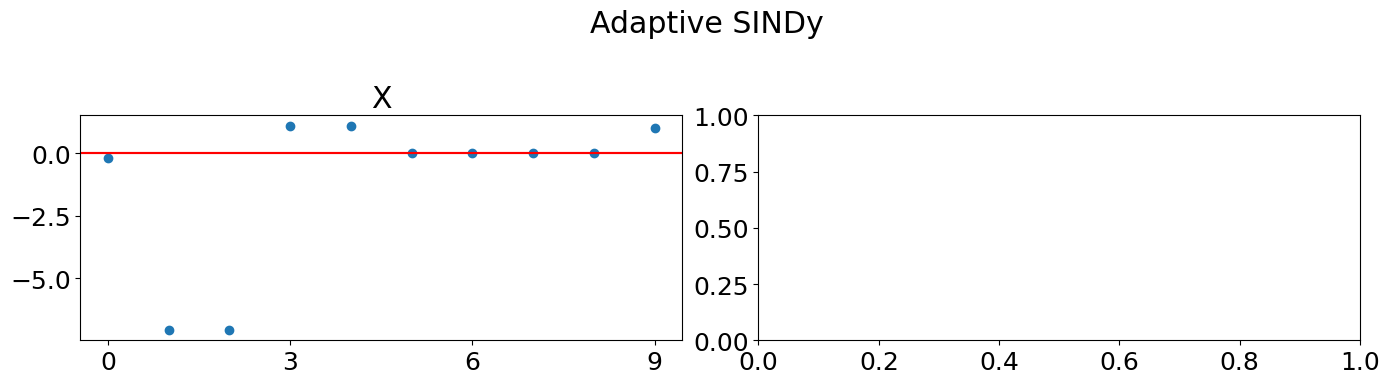

In [11]:
threshold = 0.0005
#****************************************************************************#
loc = plticker.MultipleLocator(base=3) # this locator puts ticks at regular intervals
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize =(14, 4))
fig.suptitle('Adaptive SINDy')

ax[0].plot(COEFF_ADT [:, 0].detach().cpu().numpy(), 'o')
ax[0].set_title('X')
ax[0].axhline(y =  threshold, color = 'r', linestyle = '-')
ax[0].axhline(y = -threshold, color = 'r', linestyle = '-')
ax[0].xaxis.set_major_locator(loc)

fig.subplots_adjust(top=0.8)
fig.tight_layout()
plt.show()


In [12]:
print(COEFF_ADT  [:, 0])
print(REACT_ADT  [:, 0])

tensor([-0.2000, -7.0711, -7.0711,  1.1000,  1.1000,  0.0000,  0.0000,  0.0000,
         0.0000,  1.0000], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0.3000], device='cuda:0', grad_fn=<SelectBackward0>)


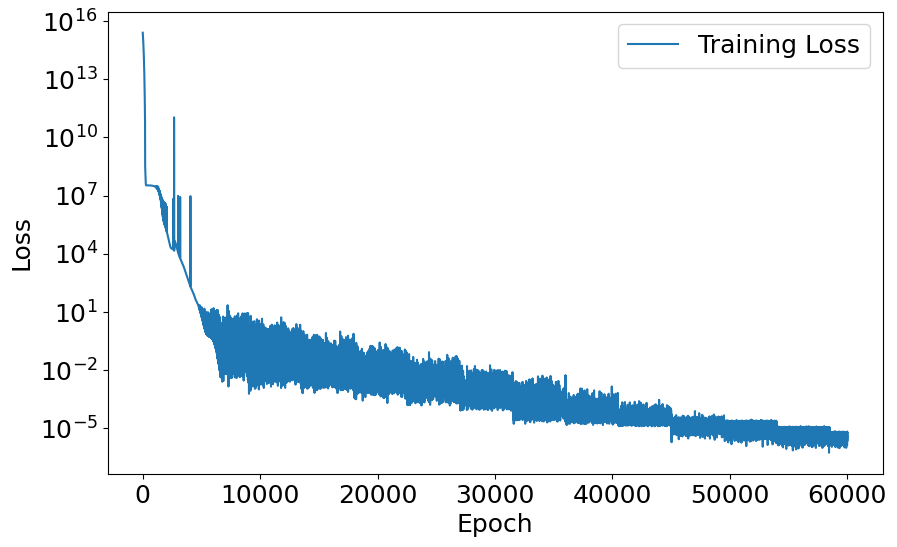

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(Loss_data.numpy(), label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid(False)
plt.savefig('Loss_plot.jpeg', dpi = 1200)
plt.show()

In [14]:
time = np.arange(Loss_data.size()[0], dtype=int)
data = np.column_stack((time, Loss_data.numpy().squeeze()))
np.savetxt('SGraD_SINDy_Wildfire.dat', data, fmt='%3.6e')